In [3]:
%pip install ultralytics

In [7]:
import ultralytics
from ultralytics import YOLO
ultralytics.checks()

Ultralytics YOLOv8.2.100 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.8/112.6 GB disk)


In [26]:
import cv2
import torch
import time
from ultralytics import YOLO
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript, clear_output
from base64 import b64decode, b64encode
from io import BytesIO
from PIL import Image
import numpy as np

# Función para convertir la respuesta de JS a una imagen de OpenCV
def js_to_image(js_reply):
    image_bytes = b64decode(js_reply.split(',')[1])
    image = Image.open(BytesIO(image_bytes))
    return np.array(image)

# Función para reducir la resolución y capturar frames menos frecuentemente
def video_stream():
    js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 320, 240);  // Captura a menor resolución
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "Status:";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          'When finished, click here or on the video to stop this demo';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 320;  // Cambiar la resolución a 320x240
      captureCanvas.height = 240;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

    display(js)



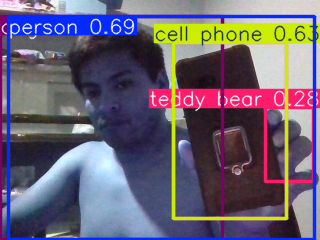

Programa finalizado


In [27]:
def video_frame(label, bbox):
    data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
    return data

# Cargar el modelo YOLO más ligero
model = YOLO("yolov8n.pt")  # Cambiar a YOLOv8n para mejor rendimiento

# Iniciar la cámara automáticamente
print("Iniciando cámara...")
video_stream()

# Esperar un poco para que el JavaScript se cargue
time.sleep(3)

print("Cámara encendida")

# Procesar el video cuadro por cuadro
camera_on = True
while True:
    try:
        js_reply = video_frame("Capturing...", "")
        if not js_reply:
            break

        # Convertir la respuesta de JS a una imagen de OpenCV
        frame = js_to_image(js_reply["img"])

        # Realizar predicción de segmentación
        results = model(frame)

        # Dibujar las máscaras y bounding boxes en la imagen
        annotated_frame = results[0].plot()

        # Mostrar el frame procesado
        clear_output(wait=True)
        cv2_imshow(annotated_frame)

    except Exception as e:
        print(f"Error: {e}")
        break

print("Programa finalizado")


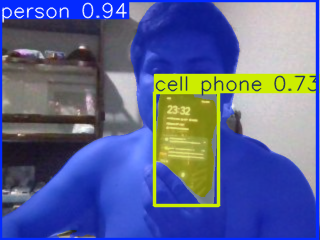

Programa finalizado


In [28]:
def video_frame(label, bbox):
    data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
    return data

# Cargar el modelo YOLO más ligero
model = YOLO("yolov8n-seg.pt")  # Cambiar a YOLOv8n para mejor rendimiento

# Iniciar la cámara automáticamente
print("Iniciando cámara...")
video_stream()

# Esperar un poco para que el JavaScript se cargue
time.sleep(3)

print("Cámara encendida")

# Procesar el video cuadro por cuadro
camera_on = True
while True:
    try:
        js_reply = video_frame("Capturing...", "")
        if not js_reply:
            break

        # Convertir la respuesta de JS a una imagen de OpenCV
        frame = js_to_image(js_reply["img"])

        # Realizar predicción de segmentación
        results = model(frame)

        # Dibujar las máscaras y bounding boxes en la imagen
        annotated_frame = results[0].plot()

        # Mostrar el frame procesado
        clear_output(wait=True)
        cv2_imshow(annotated_frame)

    except Exception as e:
        print(f"Error: {e}")
        break

print("Programa finalizado")

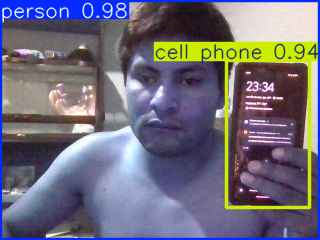

Programa finalizado


In [29]:
from ultralytics import RTDETR

def video_frame(label, bbox):
    data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
    return data

# Cargar el modelo YOLO más ligero
model = RTDETR('rtdetr-l.pt')

# Iniciar la cámara automáticamente
print("Iniciando cámara...")
video_stream()

# Esperar un poco para que el JavaScript se cargue
time.sleep(3)

print("Cámara encendida")

# Procesar el video cuadro por cuadro
camera_on = True
while True:
    try:
        js_reply = video_frame("Capturing...", "")
        if not js_reply:
            break

        # Convertir la respuesta de JS a una imagen de OpenCV
        frame = js_to_image(js_reply["img"])

        # Realizar predicción de segmentación
        results = model(frame)

        # Dibujar las máscaras y bounding boxes en la imagen
        annotated_frame = results[0].plot()

        # Mostrar el frame procesado
        clear_output(wait=True)
        cv2_imshow(annotated_frame)

    except Exception as e:
        print(f"Error: {e}")
        break

print("Programa finalizado")

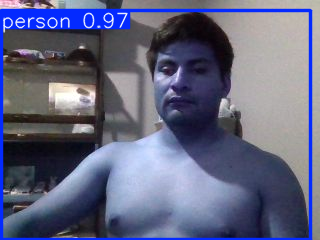

Programa finalizado


In [30]:
def video_frame(label, bbox):
    data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
    return data

# Cargar el modelo YOLO más ligero
model = YOLO("yolov9t.pt")  # Cambiar a YOLOv8n para mejor rendimiento

# Iniciar la cámara automáticamente
print("Iniciando cámara...")
video_stream()

# Esperar un poco para que el JavaScript se cargue
time.sleep(3)

print("Cámara encendida")

# Procesar el video cuadro por cuadro
camera_on = True
while True:
    try:
        js_reply = video_frame("Capturing...", "")
        if not js_reply:
            break

        # Convertir la respuesta de JS a una imagen de OpenCV
        frame = js_to_image(js_reply["img"])

        # Realizar predicción de segmentación
        results = model(frame)

        # Dibujar las máscaras y bounding boxes en la imagen
        annotated_frame = results[0].plot()

        # Mostrar el frame procesado
        clear_output(wait=True)
        cv2_imshow(annotated_frame)

    except Exception as e:
        print(f"Error: {e}")
        break

print("Programa finalizado")

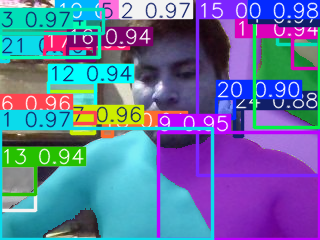

Programa finalizado


In [34]:
from ultralytics import SAM

def video_frame(label, bbox):
    data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
    return data

# Cargar el modelo YOLO más ligero
model = SAM("sam_b.pt")  # Cambiar a YOLOv8n para mejor rendimiento

# Iniciar la cámara automáticamente
print("Iniciando cámara...")
video_stream()

# Esperar un poco para que el JavaScript se cargue
time.sleep(3)

print("Cámara encendida")

# Procesar el video cuadro por cuadro
camera_on = True
while True:
    try:
        js_reply = video_frame("Capturing...", "")
        if not js_reply:
            break

        # Convertir la respuesta de JS a una imagen de OpenCV
        frame = js_to_image(js_reply["img"])

        # Realizar predicción de segmentación
        results = model(frame)

        # Dibujar las máscaras y bounding boxes en la imagen
        annotated_frame = results[0].plot()

        # Mostrar el frame procesado
        clear_output(wait=True)
        cv2_imshow(annotated_frame)

    except Exception as e:
        print(f"Error: {e}")
        break

print("Programa finalizado")

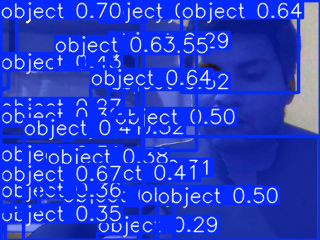

Programa finalizado


In [35]:
from ultralytics import FastSAM

def video_frame(label, bbox):
    data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
    return data

# Cargar el modelo YOLO más ligero
model = FastSAM("FastSAM-s.pt")  # or FastSAM-x.pt

# Iniciar la cámara automáticamente
print("Iniciando cámara...")
video_stream()

# Esperar un poco para que el JavaScript se cargue
time.sleep(3)

print("Cámara encendida")

# Procesar el video cuadro por cuadro
camera_on = True
while True:
    try:
        js_reply = video_frame("Capturing...", "")
        if not js_reply:
            break

        # Convertir la respuesta de JS a una imagen de OpenCV
        frame = js_to_image(js_reply["img"])

        # Realizar predicción de segmentación
        results = model(frame)

        # Dibujar las máscaras y bounding boxes en la imagen
        annotated_frame = results[0].plot()

        # Mostrar el frame procesado
        clear_output(wait=True)
        cv2_imshow(annotated_frame)

    except Exception as e:
        print(f"Error: {e}")
        break

print("Programa finalizado")